In [ ]:
%%capture
%run 1-setup.ipynb

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [ ]:
# let's standardize/normalize the numerical features of the dataframe
for df in dataframes.values():
    df[numerics] = MinMaxScaler().fit_transform(df[numerics])

In [ ]:
dataframes['modena']

Time Series Kmeans requires a 3D array, so let's create a 3D array from all the datasets

In [ ]:
provinces = dataframes.keys()

# Prepare input data
X = []

for province in provinces:
    group_data = dataframes[province][numerics].values
    
    # Reshape to (n_samples, n_timestamps, n_features)
    group_data = np.expand_dims(group_data, axis=0)
    X.append(group_data)

# Stack the list of arrays to create a 3D array
X = np.vstack(X)

In [ ]:
X

Now we have to choose the optimal number of clusters. To do this, we'll run kmeans different times for different cluster sizes.
Each time we'll save the total inertia, which is a measure of goodness of fit for clustering. It represents the sum of squared distances of all observations from the respective cluster. The lower the inertia, the more the clusters are concentrated around the centroids. For time series data, the best choice is to use Dinamic Time Warping (dtw) as metric for clustering, since Euclidean distance might introduce distortions with time series data.

In [ ]:
inertia = []
K = list(range(2, 9))

# estimation time: ~m
for k in K:
    km = TimeSeriesKMeans(n_clusters=k, n_init=5, metric='dtw', random_state=0)
    
    km = km.fit(X)
    
    inertia.append(km.inertia_)

Considering both preprocessing steps (standardization and min-max scaling) by looking at the 2 figures for the elbow method, we can deduce that it's unlikely KMeans did a good job in clustering, as there is not a clear difference in the different Ks. Ideally, we should see a number of clusters that has a clear drop with respect to the previous one, while in this case the direction is constantly decreasing almost at the same rate 

In [ ]:
plt.plot(K, inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Total sum of squares')
plt.title('Elbow method')

x_ticks = np.linspace(min(K), max(K), 7)

# Set the ticks on the x-axis
plt.xticks(x_ticks)

plt.show()

In [22]:
clusters = TimeSeriesKMeans(n_clusters=3, n_init=5, metric='dtw', random_state=0).fit_predict(X)

In [23]:
clusters

array([1, 1, 1, 1, 2, 2, 2, 0, 0], dtype=int64)

In [24]:
for df, cluster in zip(dataframes.values(), clusters):
    df['cluster'] = cluster

In [25]:
dataframes['bologna']

,date,TG,TN,TX,HU,PP,QQ,RR,CO,NH3,NMVOC,NO2,NO,O3,PANS,PM10,PM2.5,SO2,cluster
365,2018-01-01,0.195730,0.289171,0.201367,0.877106,0.941486,0.247263,0.320473,0.420590,0.204748,0.455311,0.562098,0.207060,0.169434,0.113182,0.154146,0.264886,0.245791,1
366,2018-01-02,0.289442,0.293007,0.386172,0.461943,0.949259,0.275534,0.051874,0.262819,0.057864,0.245492,0.273459,0.063136,0.281155,0.069241,0.065609,0.125765,0.181818,1
367,2018-01-03,0.247034,0.249041,0.329653,0.574910,0.940190,0.231787,0.051874,0.198829,0.098417,0.145452,0.255980,0.153428,0.248627,0.059920,0.031723,0.054535,0.202020,1
368,2018-01-04,0.280842,0.308351,0.364879,0.690584,0.935917,0.179745,0.051874,0.235781,0.190406,0.236146,0.356716,0.150034,0.251589,0.087883,0.039366,0.065943,0.202020,1
369,2018-01-05,0.238138,0.257893,0.266299,0.896811,0.939436,0.181616,0.052981,0.342556,0.265579,0.473081,0.528059,0.426341,0.121412,0.035952,0.153569,0.237062,0.225589,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,2020-12-24,0.321174,0.419298,0.250789,0.323556,0.351027,0.203439,0.000000,0.462721,0.081602,0.288272,0.301058,0.161575,0.216900,0.034621,0.220043,0.358653,0.161616,1
1454,2020-12-25,0.309015,0.361759,0.284700,0.646961,0.938779,0.253863,0.159129,0.365441,0.020277,0.362906,0.259430,0.216565,0.240232,0.026631,0.171305,0.245409,0.151515,1
1455,2020-12-26,0.289739,0.331366,0.315195,0.442088,0.953262,0.244152,0.051874,0.307960,0.227992,0.241938,0.319227,0.163612,0.234492,0.030626,0.105840,0.189482,0.323232,1
1456,2020-12-27,0.174081,0.265565,0.175868,0.433815,0.941254,0.247819,0.189035,0.307097,0.169634,0.159932,0.204462,0.089613,0.275785,0.049268,0.136410,0.223428,0.350168,1


In [26]:
full_df = pd.concat(dataframes.values(), ignore_index=True)
full_df

,date,TG,TN,TX,HU,PP,QQ,RR,CO,NH3,NMVOC,NO2,NO,O3,PANS,PM10,PM2.5,SO2,cluster
0,2018-01-01,0.195730,0.289171,0.201367,0.877106,0.941486,0.247263,0.320473,0.420590,0.204748,0.455311,0.562098,0.207060,0.169434,0.113182,0.154146,0.264886,0.245791,1
1,2018-01-02,0.289442,0.293007,0.386172,0.461943,0.949259,0.275534,0.051874,0.262819,0.057864,0.245492,0.273459,0.063136,0.281155,0.069241,0.065609,0.125765,0.181818,1
2,2018-01-03,0.247034,0.249041,0.329653,0.574910,0.940190,0.231787,0.051874,0.198829,0.098417,0.145452,0.255980,0.153428,0.248627,0.059920,0.031723,0.054535,0.202020,1
3,2018-01-04,0.280842,0.308351,0.364879,0.690584,0.935917,0.179745,0.051874,0.235781,0.190406,0.236146,0.356716,0.150034,0.251589,0.087883,0.039366,0.065943,0.202020,1
4,2018-01-05,0.238138,0.257893,0.266299,0.896811,0.939436,0.181616,0.052981,0.342556,0.265579,0.473081,0.528059,0.426341,0.121412,0.035952,0.153569,0.237062,0.225589,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9832,2020-12-24,0.567604,0.590232,0.524075,0.877699,0.977279,0.274662,0.134196,0.211916,0.047538,0.046609,0.097281,0.014337,0.348116,0.048742,0.132043,0.232422,0.176768,0
9833,2020-12-25,0.455111,0.444908,0.447617,0.878919,0.969622,0.233602,0.232044,0.200657,0.095076,0.137977,0.121391,0.041816,0.336445,0.031447,0.082770,0.099854,0.113636,0
9834,2020-12-26,0.352623,0.389220,0.322284,0.695420,0.974014,0.264832,0.506688,0.253697,0.027165,0.132761,0.105971,0.004779,0.291014,0.033019,0.082872,0.088623,0.169192,0
9835,2020-12-27,0.272580,0.279333,0.285023,0.735780,0.969077,0.259276,0.135068,0.297760,0.252971,0.147232,0.201570,0.087216,0.293098,0.077044,0.074985,0.126465,0.234848,0


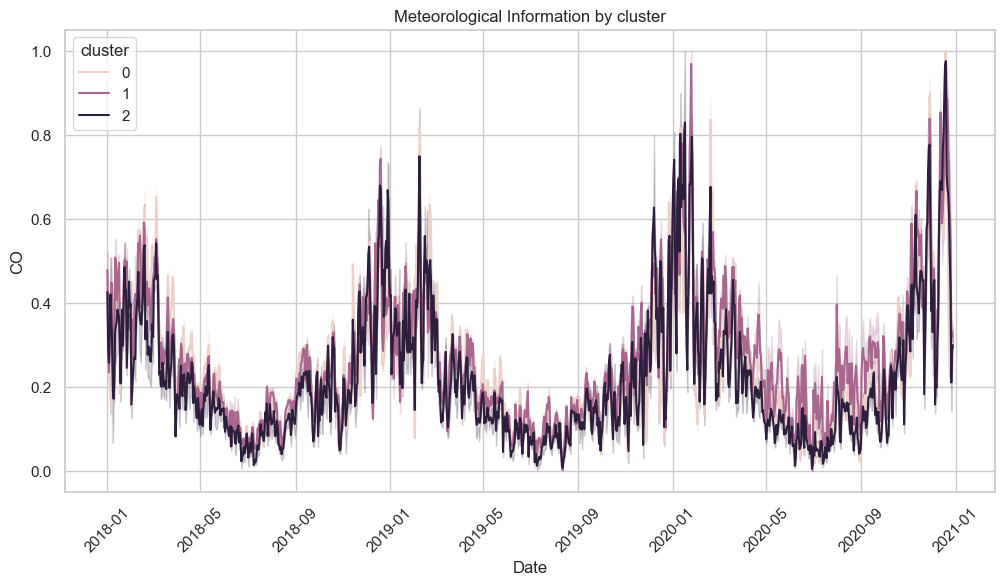

In [28]:
# Set the style of seaborn for better aesthetics
sns.set(style="whitegrid")

for var in pollutants:
    
    # Plot the time series for each province
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='date', y=var, hue='cluster', data=full_df)

    plt.title('Meteorological Information by cluster')
    plt.xlabel('Date')
    plt.ylabel(var)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    plt.show()